# Sentiment Analysis

## Environment Setup

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
import json
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from keras.preprocessing.text import one_hot, Tokenizer
from sklearn.model_selection import train_test_split

## Model Loading and Understanding

In [7]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

In [8]:
movie_reviews.shape

(50000, 2)

In [9]:
# Check for missing values

movie_reviews.isnull().values.any()

False

In [10]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
movie_reviews["review"][2]

## Result shows that it has HTML Tags, punctuations, bracket and numbers

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

<AxesSubplot:xlabel='sentiment', ylabel='count'>

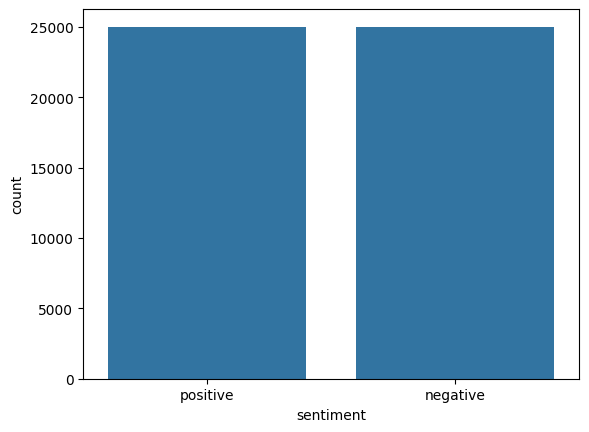

In [12]:
import seaborn as sns
sns.countplot(x = "sentiment", data = movie_reviews)

## Data Preprocessing

In [13]:
# Remove HTML Tags

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def preprocess_text(sen):
    
    sentence = sen.lower()
    
    # Remove html tags
    sentence = remove_tags(sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    # Remove the character that left after the punctuations removal done 
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Remove multiple spaces
    # The multiple spaces are caused by the single character removal which replace by a blank space
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    
    return sentence

In [16]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [17]:
# Check the review after preprocessing
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [18]:
# Convert label from string to boolean in this case (binary classification)
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
print(y_train[:10])

[0 0 1 0 0 0 0 0 1 0]


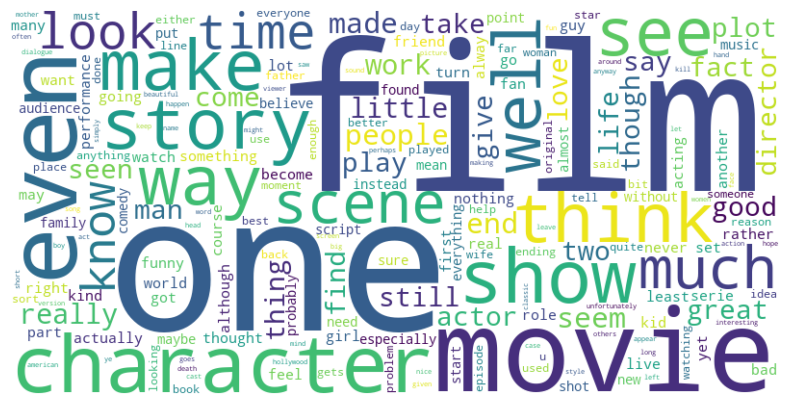

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text in X_train into a single string
all_text = ' '.join(X_train)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

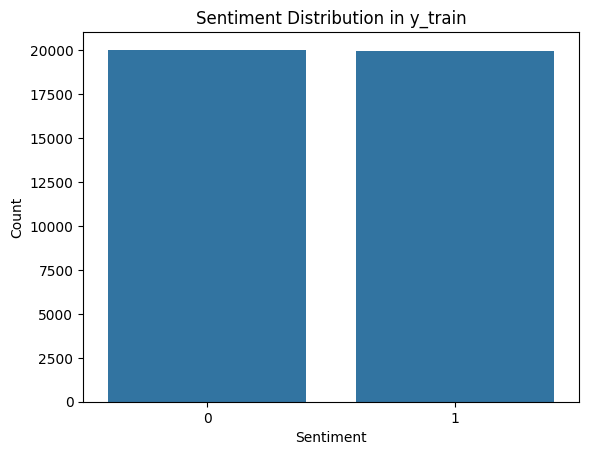

In [22]:
# Plot the sentiment distribution
sns.countplot(x=y_train)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in y_train')
plt.show()

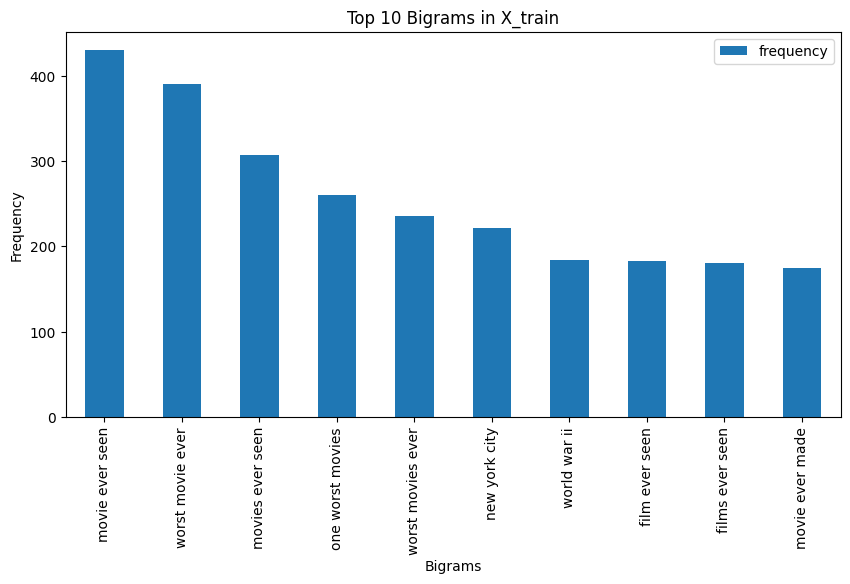

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the CountVectorizer for bigrams
vectorizer = CountVectorizer(ngram_range=(3, 3))

X_train_bigrams = vectorizer.fit_transform(X_train)

# Sum the counts of each bigram across all documents
bigrams_sum = X_train_bigrams.sum(axis=0)

# Convert the result to a dictionary mapping bigram to its frequency
bigram_freq = [(bigram, bigrams_sum[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Convert to a DataFrame for easier plotting (optional)
bigram_df = pd.DataFrame(bigram_freq, columns=['bigram', 'frequency'])


bigram_df.head(10).plot(kind='bar', x='bigram', y='frequency', figsize=(10, 5))
plt.title('Top 10 Bigrams in X_train')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.show()

## Preparing embedding layer

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
vocab_length = len(tokenizer.word_index)+1

vocab_length

92394

In [28]:
# Do padding on the reviews to fixed length 100

maxlen = 100

X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen= maxlen)

In [29]:
from numpy import asarray
from numpy import zeros

# Load the pre-trained embedding text file from glove
embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [30]:
# Create Embedding Matrix with 100 columns 
# Containing 100-dimensional glove word embeddings for all words in the corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [31]:
embedding_matrix.shape

(92394, 100)

## Model Training

In [32]:
from keras.layers import LSTM

In [33]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

In [34]:
model = keras.Sequential([
    layers.Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.SpatialDropout1D(0.2),  
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)), 
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid'),
])

In [35]:
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics = ['accuracy'],
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

Total params: 9,490,409
Trainable params: 251,009
Non-trainable params: 9,239,400
_________________________________________________________________
None


In [36]:
history = model.fit(X_train, y_train, 
                    batch_size=128, epochs=10, 
                    verbose=1, validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 20s 48ms/step - loss: 0.5514 - accuracy: 0.7147 - val_loss: 0.4430 - val_accuracy: 0.8054
Epoch 2/10
250/250 [==============================] - 14s 55ms/step - loss: 0.4640 - accuracy: 0.7868 - val_loss: 0.3929 - val_accuracy: 0.8267
Epoch 3/10
250/250 [==============================] - 14s 57ms/step - loss: 0.4122 - accuracy: 0.8179 - val_loss: 0.3539 - val_accuracy: 0.8444
Epoch 4/10
250/250 [==============================] - 12s 47ms/step - loss: 0.3805 - accuracy: 0.8335 - val_loss: 0.3379 - val_accuracy: 0.8570
Epoch 5/10
250/250 [==============================] - 10s 40ms/step - loss: 0.3584 - accuracy: 0.8438 - val_loss: 0.3460 - val_accuracy: 0.8577
Epoch 6/10
250/250 [==============================] - 12s 50ms/step - loss: 0.3412 - accuracy: 0.8539 - val_loss: 0.3385 - val_accuracy: 0.8480
Epoch 7/10
250/250 [==============================] - 14s 58ms/step - loss: 0.3248 - accuracy: 0.8602 - val_loss: 0.3157 - val_accuracy:

In [37]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 5s 16ms/step - loss: 0.3140 - accuracy: 0.8699


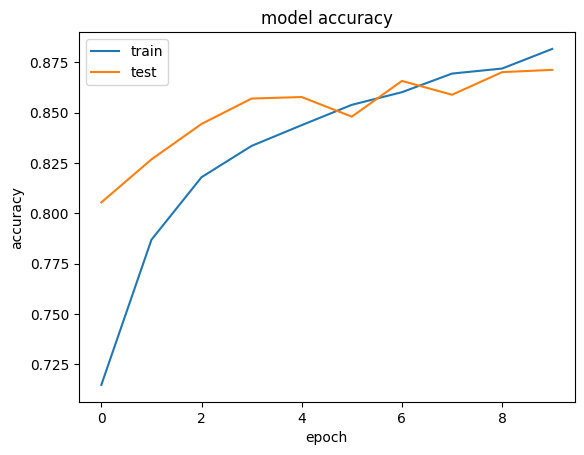

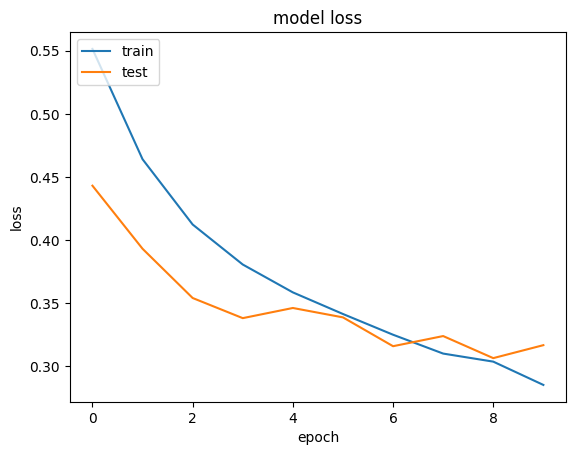

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [39]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred_class = (y_pred_prob > 0.5).astype(int)

313/313 [==============================] - 6s 15ms/step


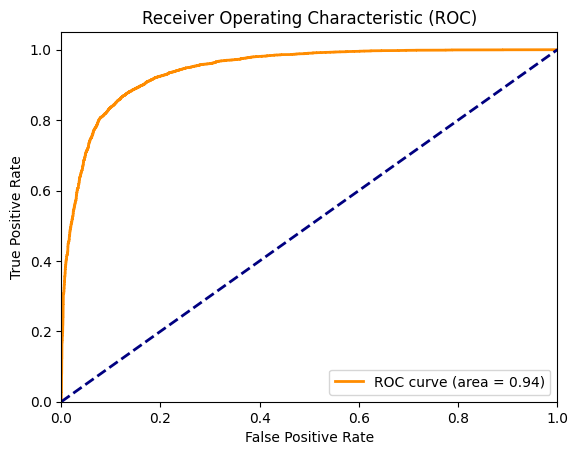

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [41]:
report = classification_report(y_test, y_pred_class, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.86      0.89      0.87      4961
    Positive       0.89      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



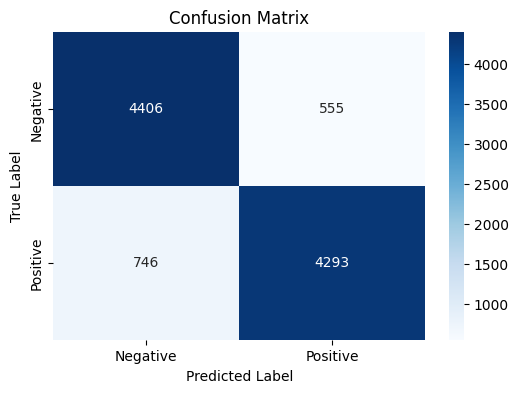

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
model.save("sentiment_model.h5")